In [8]:
import os
from astropy.io import fits
import numpy as np
from astropy.visualization import MinMaxInterval, SqrtStretch, ImageNormalize, simple_norm, AsinhStretch, PercentileInterval
from astropy.visualization import make_lupton_rgb
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.stats import sigma_clipped_stats, SigmaClip
from photutils.background import Background2D, SExtractorBackground, MedianBackground
from PIL import Image
from scipy.stats import skew, kurtosis
import h5py
from astropy.convolution import convolve, Gaussian2DKernel
import pywt
from scipy.ndimage import label, binary_dilation
import time
import cv2

### Functions

In [2]:
def load_fits(file_path, ext=0):
    if ('calexp' in file_path) or ('WISHES' in file_path):
        ext = 1
    if ('single' in file_path):
        ext = 0
    with fits.open(file_path, memmap=True) as hdul:
        data = hdul[ext].data.astype(np.float64)
        header = hdul[ext].header
    return data, header

def scale_image(data):
    norm = ImageNormalize(data, interval=MinMaxInterval(), stretch=SqrtStretch())
    return norm(data)

def asinh_scale_image(data):
    norm = ImageNormalize(data, interval=MinMaxInterval(), stretch=AsinhStretch(a=0.4))  # 'a' parameter controls the steepness
    return norm(data)

def apply_asinh_stretch(data, lower_percentile=1, upper_percentile=98, a_value=0.01):
    interval = PercentileInterval(lower_percentile, upper_percentile)
    norm = ImageNormalize(data, interval=interval, stretch=AsinhStretch(a=a_value))
    return norm(data)

def adjust_rgb_balance(rgb, r_factor, g_factor, b_factor):
    red, green, blue = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    balanced_rgb = np.stack([red * r_factor, green * g_factor, blue * b_factor], axis=-1)
    return np.clip(balanced_rgb, 0, 1)  # Clip to avoid overflows

def remove_background(data, bg_mesh=128, neg_thresh=-0.1):
    sigma_clip = SigmaClip(sigma=3.0)
    bkg_estimator = SExtractorBackground()
    bkg = Background2D(data, (bg_mesh, bg_mesh), filter_size=(3, 3), sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
    data_sub = data - bkg.background
    neg_mask = data_sub < neg_thresh
    nan_mask = np.isnan(data)
    mask = (neg_mask == 1) | (nan_mask == 1)
    gaussian_noise = np.random.normal(0, bkg.background_rms_median, np.count_nonzero(mask))
    data_sub[mask!=0] = gaussian_noise
    data[mask!=0] = gaussian_noise
    return data_sub, data

def estimate_background(data, bg_mesh=128):
    sigma_clip = SigmaClip(sigma=3.0)
    bkg_estimator = SExtractorBackground()
    bkg = Background2D(data, (bg_mesh, bg_mesh), filter_size=(3, 3), sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
    return bkg.background_rms_median

def show_rgb_image(rgb_image):
    plt.clf()
    plt.close('all')
    norm = simple_norm(rgb_image, 'sqrt', percent=95.)
    plt.figure(figsize=(8,8))
    plt.imshow(rgb_image, origin='lower', norm=norm)
    
    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    
    plt.show()
    
def adjust_rgb_channels(rgb_image, r_factor, g_factor, b_factor):
    # Split the image into its respective color channels
    red, green, blue = rgb_image[:, :, 0], rgb_image[:, :, 1], rgb_image[:, :, 2]
    
    # Apply the factors
    red = np.clip(red * r_factor, 0, 255)
    green = np.clip(green * g_factor, 0, 255)
    blue = np.clip(blue * b_factor, 0, 255)
    
    # Reassemble the adjusted image
    adjusted_rgb_image = np.stack([red, green, blue], axis=-1).astype(np.uint8)
    return adjusted_rgb_image

def save_to_fits(data, header, filepath, filename):
    hdu = fits.PrimaryHDU(data.astype(np.float32), header=header)
    hdulist = fits.HDUList([hdu])
    hdulist.writeto(os.path.join(filepath, filename), overwrite=True)
    
def single_ext(input_filename, output_filename):
    """
    Extracts data from the first extension of a FITS file and saves it as the primary HDU
    in a new FITS file.

    Parameters:
    input_filename (str): The path to the original FITS file.
    output_filename (str): The path where the new FITS file will be saved.
    """
    # Open the original FITS file and extract data and header from the first extension
    with fits.open(input_filename) as hdul:
        data = hdul[1].data
        header = hdul[1].header

    # Create a new Primary HDU with the extracted data and header
    new_hdu = fits.PrimaryHDU(data=data, header=header)

    # Create an HDUList and write it to a new file
    new_hdulist = fits.HDUList([new_hdu])
    new_hdulist.writeto(output_filename, overwrite=True)
    print(f"New FITS file created: {output_filename}")
    
def scale_info(header):
    pix_scale = abs(header['CD1_1']*3600)
    dim_x_arcsec = header['NAXIS1']*pix_scale
    dim_y_arcsec = header['NAXIS2']*pix_scale
    dim_x_deg = np.round(dim_x_arcsec/3600,3)
    dim_y_deg = np.round(dim_y_arcsec/3600,3)
    return pix_scale, dim_x_deg, dim_y_deg

def adjust_flux_with_zp(flux, current_zp, standard_zp):
    adjusted_flux = flux * 10**(-0.4 * (current_zp - standard_zp))
    return adjusted_flux

def preprocess(file_path, sub_bg=True, bg_mesh=128, neg_thresh=-8.0, rescale_flux=False, current_zp=30.0, std_zp=30.0, save_fits=False):
    """
    Preprocesses data to bring it to a common frame with other data.
    Args:
        file_path: path to file
        sub_bg: subtract the background
        bg_mesh: background mesh size
        neg_thresh: replace pixels that have values lower than this with background noise
        rescale_flux: rescale flux to a different zero-point
        current_zp: current zero-point
        std_zp: new zero-point
        save_fits: save to file
    Returns:
        preprocessed data
    """
    
    data, header = load_fits(file_path)
    new_path = file_path
    
    if sub_bg:
        sigma_clip = SigmaClip(sigma=3.0)
        bkg_estimator = SExtractorBackground()
#         bkg_estimator = MedianBackground()
        bkg = Background2D(data, (bg_mesh, bg_mesh), filter_size=(3, 3), sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
        data = data - bkg.background
#         data = data - bkg.background_median
        neg_mask = data < neg_thresh
        nan_mask = np.isnan(data)
        mask = (neg_mask == 1) | (nan_mask == 1)
        gaussian_noise = np.random.normal(0, bkg.background_rms_median, np.count_nonzero(mask))
        data[mask!=0] = gaussian_noise
        
    if rescale_flux:
        data = data * 10**(-0.4 * (current_zp - std_zp))
        
    if save_fits:
        hdu = fits.PrimaryHDU(data.astype(np.float32), header=header)
        hdulist = fits.HDUList([hdu])
        dir_path, filename = os.path.split(file_path)
        modified_filename = 'adj_' + filename
        new_path = os.path.join(dir_path, modified_filename)
        hdulist.writeto(new_path, overwrite=True)
    return data, new_path

def colour_image(
    img,
    scaling_type='asinh',  # Default to 'asinh', can also use 'linear'
    stretch=0.5,
    Q=10,
    m=0,
    ceil_percentile=99.995,
    dtype=np.uint8,
    do_norm=True,
    scaling_factor=1.5,
    gamma=0.8,
    scale_red=1.0,
    scale_green=1.0,
    scale_blue=1.0,
):
    def norm(red, green, blue, scale_red, scale_green, scale_blue):
        red = red / np.nanpercentile(red, ceil_percentile)
        green = green / np.nanpercentile(green, ceil_percentile)
        blue = blue / np.nanpercentile(blue, ceil_percentile)

        max_dtype = np.iinfo(dtype).max
        red = np.clip((red * max_dtype), 0, max_dtype)
        green = np.clip((green * max_dtype), 0, max_dtype)
        blue = np.clip((blue * max_dtype), 0, max_dtype)

        image[:, :, 0] = scale_red*red  # Red
        image[:, :, 1] = scale_green*green  # Green
        image[:, :, 2] = scale_blue*blue  # Blue
        return image

    red = img[:, :, 0]
    green = img[:, :, 1]
    blue = img[:, :, 2]

    # Compute average intensity before scaling choice
    I = (red + green + blue) / 3.0

    length, width = green.shape
    image = np.empty([length, width, 3], dtype=dtype)

    if scaling_type == 'asinh':
        # Apply asinh scaling
        red = red * np.arcsinh(stretch * Q * (I - m)) / (Q * I)
        green = green * np.arcsinh(stretch * Q * (I - m)) / (Q * I)
        blue = blue * np.arcsinh(stretch * Q * (I - m)) / (Q * I)
    elif scaling_type == 'linear':
        # Apply linear scaling
        max_val = np.nanpercentile(I, ceil_percentile)
        red = (red / max_val) * np.iinfo(dtype).max
        green = (green / max_val) * np.iinfo(dtype).max
        blue = (blue / max_val) * np.iinfo(dtype).max

    # Optionally apply gamma correction
    if gamma is not None:
        red = np.clip((red ** gamma), 0, np.iinfo(dtype).max)
        green = np.clip((green ** gamma), 0, np.iinfo(dtype).max)
        blue = np.clip((blue ** gamma), 0, np.iinfo(dtype).max)

    if do_norm:
        return norm(red, green, blue, scale_red, scale_green, scale_blue)
    else:
        return np.stack([red, green, blue], axis=-1)

def zscale(data):
    mean = np.nanmean(data)
    std = np.nanstd(data)
    return (data - mean) / (std + 1e-6)

def compute_image_statistics(image):
    if isinstance(image, str):
        # Load the image as a grayscale image
        image, header = load_fits(image)
    
    # Flatten the image to 1D array for statistical analysis
    pixel_values = image.flatten()
    
    # Compute statistics
    mean_val = np.mean(pixel_values)
    median_val = np.median(pixel_values)
    std_dev = np.std(pixel_values)
    variance_val = np.var(pixel_values)
    skewness_val = skew(pixel_values)
    kurtosis_val = kurtosis(pixel_values)
    
    # Print the computed values
    print("Mean:", mean_val)
    print("Median:", median_val)
    print("Standard Deviation:", std_dev)
    print("Variance:", variance_val)
    print("Skewness:", skewness_val)
    print("Kurtosis:", kurtosis_val)
    
def image_stats(data, df, band):
    pixel_values = data.flatten()
    valid_mask = np.isfinite(pixel_values)
    n_valid_pixels = np.count_nonzero(valid_mask)
    frac_zeros = np.count_nonzero(pixel_values == 0.0)/n_valid_pixels
    valid_pixels = pixel_values[valid_mask]
    sum_pixels = np.sum(valid_pixels)
    sum_pixels_squared = np.sum(valid_pixels**2)
    nanmin = np.min(valid_pixels)
    nanmax = np.max(valid_pixels)
    kurt = kurtosis(valid_pixels)
    
    df[f'{band}_n_valid_pixels'] = n_valid_pixels
    df[f'{band}_sum_pixel_values'] = sum_pixels
    df[f'{band}_sum_pixel_values_squared'] = sum_pixels_squared
    df[f'{band}_min'] = nanmin
    df[f'{band}_max'] = nanmax
    df[f'{band}_frac_zeros'] = frac_zeros
    df[f'{band}_kurtosis'] = kurt
    
    return df

def read_h5(cutout_dir):
    """
    Reads cutout data from HDF5 file
    :param cutout_dir: cutout directory
    :return: cutout data
    """
    with h5py.File(cutout_dir, 'r') as f:
        # Create empty dictionaries to store data for each group
        cutout_data = {}

        # Loop through datasets
        for dataset_name in f:
            data = np.array(f[dataset_name])
            cutout_data[dataset_name] = data
    return cutout_data

def plot_fourier_transform(image):
    if isinstance(image, str):
        # Load the image as a grayscale image
        image, header = load_fits(image)
    
    # Compute the 2D Fourier Transform of the image
    f_transform = np.fft.fft2(image)
    
    # Shift the zero frequency component (DC component) to the center
    f_shifted = np.fft.fftshift(f_transform)
    
    # Compute the magnitude spectrum of the Fourier Transform
    magnitude_spectrum = np.log(np.abs(f_shifted) + 1)  # Adding 1 to avoid log(0)
    
    # Plot the original image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    norm = simple_norm(image, 'sqrt', percent=98.)
    plt.imshow(image, cmap='gray_r', norm=norm, origin='lower')
    plt.title('Original Image')
    plt.axis('off')
    
    # Plot the magnitude spectrum
    plt.subplot(1, 2, 2)
    norm = simple_norm(magnitude_spectrum, 'sqrt', percent=98.)
    plt.imshow(magnitude_spectrum, cmap='gray_r', norm=norm, origin='lower')
    plt.title('Fourier Magnitude Spectrum')
    plt.axis('off')

    plt.tight_layout()
    
    plt.show()
    
def detect_anomaly_fourier(image, with_smooth=False, with_plot=False):
    plt.close('all')
    if isinstance(image, str):
        image, header = load_fits(image)
    
    f_transform = np.fft.fft2(image)
    f_shifted = np.fft.fftshift(f_transform)
    
    magnitude_spectrum = np.abs(f_shifted)

    if with_smooth:
        gaussian_kernel = Gaussian2DKernel(x_stddev=1)
        magnitude_spectrum = convolve(magnitude_spectrum, gaussian_kernel)
    
    rows, cols = magnitude_spectrum.shape
    center_row, center_col = rows // 2, cols // 2

    if cols > 500:
        cross_width = 20  # Define the width of the section to analyze
        cross_length = 3000
        corner_size = 3000
    else:
        cross_width = 3  # Define the width of the section to analyze
        cross_length = 80
        corner_size = 80
        
    half_section_width = cross_width // 2

    # Define central sections
    top_center_indices = (slice(rows - cross_length, rows), slice(center_col - half_section_width, center_col + half_section_width + 1))
    bottom_center_indices = (slice(0, cross_length), slice(center_col - half_section_width, center_col + half_section_width + 1))
    left_center_indices = (slice(center_row - half_section_width, center_row + half_section_width + 1), slice(0, cross_length))
    right_center_indices = (slice(center_row - half_section_width, center_row + half_section_width + 1), slice(cols - cross_length, cols))

    # Define corner sections
    top_left_corner_indices = (slice(rows - corner_size, rows), slice(0, corner_size))
    top_right_corner_indices = (slice(rows - corner_size, rows), slice(cols - corner_size, cols))
    bottom_left_corner_indices = (slice(0, corner_size), slice(0, corner_size))
    bottom_right_corner_indices = (slice(0, corner_size), slice(cols - corner_size, cols))
    
    if with_plot:
        # Plot the magnitude spectrum
        plt.figure(figsize=(8, 8))
        norm = simple_norm(magnitude_spectrum, 'sqrt', percent=98.)
        plt.imshow(magnitude_spectrum, cmap='gray', norm=norm, origin='lower', extent=[0, cols, 0, rows])
    
        def add_rectangle(indices, color):
            row_start, row_stop = indices[0].start, indices[0].stop
            col_start, col_stop = indices[1].start, indices[1].stop
            rect = plt.Rectangle((col_start, row_start), col_stop - col_start, row_stop - row_start,
                                 linewidth=2, edgecolor=color, facecolor='none')
            plt.gca().add_patch(rect)
    
        # Overlay colored rectangles to highlight areas
        for indices, color in zip([top_center_indices, bottom_center_indices, left_center_indices, right_center_indices, 
                                   top_left_corner_indices, top_right_corner_indices, bottom_left_corner_indices, bottom_right_corner_indices],
                                  ['blue', 'blue', 'red', 'red', 'green', 'green', 'green', 'green']):
            add_rectangle(indices, color)
    
        plt.title('Fourier Magnitude Spectrum with Highlighted Sections')
        plt.axis('off')
        plt.show()

    # Calculate mean intensities
    mean_vertical_cross = (np.sum(magnitude_spectrum[top_center_indices]) + np.sum(magnitude_spectrum[bottom_center_indices])) / \
                            (np.size(magnitude_spectrum[top_center_indices]) + np.size(magnitude_spectrum[bottom_center_indices]))
    mean_horizontal_cross = (np.sum(magnitude_spectrum[left_center_indices]) + np.sum(magnitude_spectrum[right_center_indices])) / \
                          (np.size(magnitude_spectrum[left_center_indices]) + np.size(magnitude_spectrum[right_center_indices]))
    mean_corners_intensity = (np.sum(magnitude_spectrum[top_left_corner_indices]) + np.sum(magnitude_spectrum[top_right_corner_indices]) +
                              np.sum(magnitude_spectrum[bottom_left_corner_indices]) + np.sum(magnitude_spectrum[bottom_right_corner_indices])) / \
                             (np.size(magnitude_spectrum[top_left_corner_indices]) + np.size(magnitude_spectrum[top_right_corner_indices]) +
                              np.size(magnitude_spectrum[bottom_left_corner_indices]) + np.size(magnitude_spectrum[bottom_right_corner_indices]))

    print(f"Mean Horizontal Cross Intensity: {mean_horizontal_cross}")
    print(f"Mean Vertical Cross Intensity: {mean_vertical_cross}")
    print(f"Mean Corners Intensity: {mean_corners_intensity}")
    print(f'Horizontal Ratio: {mean_horizontal_cross/mean_corners_intensity}')
    print(f'Vertical Ratio: {mean_vertical_cross/mean_corners_intensity}')
    
    anomaly_threshold = 3.
    horizontal_anomaly = mean_horizontal_cross > anomaly_threshold * mean_corners_intensity
    vertical_anomaly = mean_vertical_cross > anomaly_threshold * mean_corners_intensity

    if horizontal_anomaly and vertical_anomaly:
        print("Anomaly detected.")
        return True
    else:
        print("No anomaly detected.")
        return False
    
def detect_anomaly(
    image,
    figure_path,
    file_out,
    zero_threshold=0.0025,
    min_size=50,
    bkg_rms=0.0,
    replace_anomaly=False,
    dilate_mask=False,
    dilation_iters=1,
    show_plot=False,
    save_plot=False,
):
    # Takes both data or path to file
    if isinstance(image, str):
        image, header = load_fits(image)

    # Perform a 2D Discrete Wavelet Transform using Haar wavelets
    coeffs = pywt.dwt2(image, 'haar')
    cA, (cH, cV, cD) = coeffs  # Decomposition into approximation and details

    # Create binary masks where wavelet coefficients are below the threshold
    mask_horizontal = np.abs(cH) <= zero_threshold
    mask_vertical = np.abs(cV) <= zero_threshold
    mask_diagonal = np.abs(cD) <= zero_threshold

    masks = [mask_diagonal, mask_horizontal, mask_vertical]

    global_mask = np.zeros_like(image, dtype=bool)
    component_masks = np.zeros((3, cA.shape[0], cA.shape[1]), dtype=bool)
    anomalies = np.zeros(3, dtype=bool)
    for i, mask in enumerate(masks):
        # Apply connected-component labeling to find connected regions in the mask
        labeled_array, num_features = label(mask)  # type: ignore

        # Calculate the sizes of all components
        component_sizes = np.bincount(labeled_array.ravel())

        anomaly_detected = np.any(component_sizes[1:] >= min_size)
        anomalies[i] = anomaly_detected

        if not anomaly_detected:
            continue

        # Prepare to accumulate a total mask
        total_feature_mask = np.zeros_like(image, dtype=bool)

        # Loop through all labels to find significant components
        for component_label in range(1, num_features + 1):  # Start from 1 to skip background
            if component_sizes[component_label] >= min_size:
                # Create a binary mask for this component
                component_mask = labeled_array == component_label
                # add component mask to component masks
                component_masks[i] |= component_mask
                # Upscale the mask to match the original image dimensions
                upscaled_mask = np.kron(component_mask, np.ones((2, 2), dtype=bool))
                # Accumulate the upscaled feature mask
                total_feature_mask |= upscaled_mask

        # Accumulate global mask
        global_mask |= total_feature_mask
        # Dilate the masks to catch some odd pixels on the outskirts of the anomaly
        if dilate_mask:
            global_mask = binary_dilation(global_mask, iterations=dilation_iters)
            for i, comp_mask in enumerate(component_masks):
                component_masks[i] = binary_dilation(comp_mask, iterations=dilation_iters)
    # Replace the anomaly with gaussian sky noise
    if replace_anomaly:
        bkg_rms = estimate_background(image)
        # Generate gaussian noise based on the estimated background rms
        gaussian_noise = np.random.normal(0, bkg_rms, np.count_nonzero(global_mask))
        # Modify the original image using the accumulated total mask
        image_mod = image.copy()
        image_mod[global_mask] = gaussian_noise

    if show_plot:
        plt.figure(figsize=(8, 8), constrained_layout=True)
        # Original image
        plt.subplot(231)
        norm = simple_norm(image, 'sqrt', percent=96.0)
        plt.imshow(image, cmap='gray_r', origin='lower', norm=norm)  # type: ignore
        plt.title('Original Image')
        plt.axis('off')
        # Modified image
        plt.subplot(232)
        if not replace_anomaly:
            image_mod = image
        norm_mod = simple_norm(image_mod, 'sqrt', percent=96.0)
        plt.imshow(image_mod, cmap='gray_r', origin='lower', norm=norm_mod)  # type: ignore
        if np.any(global_mask):
            plt.imshow(global_mask, cmap='Reds', vmin=0, alpha=0.5, origin='lower')
        plt.title('Modified Image')
        plt.axis('off')
        # Diagonal coefficients
        plt.subplot(234)
        norm_cD = simple_norm(cD, 'sqrt', percent=96.0)
        plt.imshow(cD, cmap='gray_r', origin='lower', norm=norm_cD)  # type: ignore
        if np.any(component_masks[0] > 0.0):
            plt.imshow(
                component_masks[0], cmap='Reds', vmin=0, alpha=0.5, origin='lower'
            )  # Overlay connected components
        plt.title('Diagonal Coefficients')
        plt.axis('off')
        # Horizontal coefficients
        plt.subplot(235)
        norm_cH = simple_norm(cH, 'sqrt', percent=96.0)
        plt.imshow(cH, cmap='gray_r', origin='lower', norm=norm_cH)  # type: ignore
        if np.any(component_masks[1] > 0.0):
            plt.imshow(
                component_masks[1], cmap='Reds', vmin=0, alpha=0.5, origin='lower'
            )  # Overlay connected components
        plt.title('Horizontal Coefficients')
        plt.axis('off')
        # Vertical coefficients
        plt.subplot(236)
        norm_cV = simple_norm(cV, 'sqrt', percent=96.0)
        plt.imshow(cV, cmap='gray_r', origin='lower', norm=norm_cV)  # type: ignore
        if np.any(component_masks[2] > 0.0):
            plt.imshow(
                component_masks[2], cmap='Reds', vmin=0, alpha=0.5, origin='lower'
            )  # Overlay connected components
        plt.title('Vertical Coefficients')
        plt.axis('off')
        plt.show()

        if save_plot:
            plt.savefig(
                os.path.join(figure_path, f'{file_out}.pdf'),
                bbox_inches='tight',
                dpi=300,
            )
        else:
            plt.close()

    return anomalies

### Paths

In [3]:
file_dir = '/home/nick/astro/UNIONS/lsb-detection-pipeline/NGC5457_test/fields/CFIS_LSB.243.290.r'
file_dir2 = '/home/nick/astro/UNIONS/lsb-detection-pipeline/NGC5457_test/fields/CFIS_LSB.246.289.r'
file_i = 'DR4.243.290.i.fits'
file_i2 = 'PS-DR3.246.289.i.fits'
file_g = 'calexp-CFIS_243_290.fits'
file_g2 = 'calexp-CFIS_246_289.fits'
file_r = 'CFIS.243.290.r.fits'
file_r_lsb = 'CFIS_LSB.243.290.r.fits'
file_r2 = 'CFIS.246.289.r.fits'
file_z = 'WISHES.243.290.z.fits'
file_z2 = 'WISHES.246.289.z.fits'
file_z3 = 'WISHES.209.285.z.fits'
file_path_i = os.path.join(file_dir, file_i)
file_path_i2 = os.path.join(file_dir2, file_i2)
file_path_g = os.path.join(file_dir, file_g)
file_path_g2 = os.path.join(file_dir2, file_g2)
file_path_r = os.path.join(file_dir, file_r)
file_path_r_lsb = os.path.join(file_dir, file_r_lsb)
file_path_r2 = os.path.join(file_dir2, file_r2)
file_path_z = os.path.join(file_dir, file_z)
file_path_z2 = os.path.join(file_dir2, file_z2)
file_path_z3 = os.path.join(file_dir, file_z3)

save_files = False
sub_back = False

# data_g, header_g = load_fits(file_path_g, 1)
# single_ext(file_path_g, os.path.join(file_dir, f'single_{file_g}'))
# file_path_g = os.path.join(file_dir, f'single_{file_g}')
# data_g, file_path_g = preprocess(file_path_g, sub_bg=sub_back, bg_mesh=128, neg_thresh=-0.3, rescale_flux=True, current_zp=27.0, std_zp=30.0, save_fits=save_files)

# data_g2, header_g2 = load_fits(file_path_g2, 1)
# single_ext(file_path_g2, os.path.join(file_dir2, f'single_{file_g2}'))
# file_path_g2 = os.path.join(file_dir2, f'single_{file_g2}')
# data_g2, file_path_g2 = preprocess(file_path_g2, sub_bg=sub_back, bg_mesh=128, neg_thresh=-0.3, rescale_flux=True, current_zp=27.0, std_zp=30.0, save_fits=save_files)

# data_r, header_r = load_fits(file_path_r, 0)
# data_r, file_path_r = preprocess(file_path_r, sub_bg=sub_back, bg_mesh=128, neg_thresh=-9.0, rescale_flux=False, current_zp=30.0, std_zp=27.0, save_fits=save_files)

# data_r_lsb, _ = load_fits(file_path_r_lsb, 0)
# data_r_lsb, file_path_r_lsb = preprocess(file_path_r_lsb, sub_bg=sub_back, bg_mesh=128, neg_thresh=-9.0, rescale_flux=False, current_zp=30.0, std_zp=27.0, save_fits=save_files)

# data_r2, header_r2 = load_fits(file_path_r2, 0)
# data_r2, file_path_r2 = preprocess(file_path_r2, sub_bg=sub_back, bg_mesh=128, neg_thresh=-9.0, rescale_flux=False, current_zp=30.0, std_zp=27.0, save_fits=save_files)

# data_i, header_i = load_fits(file_path_i, 0)
# data_i, file_path_i = preprocess(file_path_i, sub_bg=sub_back, bg_mesh=128, neg_thresh=-50.0, rescale_flux=False, current_zp=30.0, std_zp=27.0, save_fits=save_files)

# data_i2, header_i2 = load_fits(file_path_i2, 0)
# data_i2, file_path_i2 = preprocess(file_path_i2, sub_bg=sub_back, bg_mesh=128, neg_thresh=-50.0, rescale_flux=False, current_zp=30.0, std_zp=27.0, save_fits=save_files)


# data_z, header_z = load_fits(file_path_z, 1)
# single_ext(file_path_z, os.path.join(file_dir, f'single_{file_z}'))
# file_path_z = os.path.join(file_dir, f'single_{file_z}')
# data_z, file_path_z = preprocess(file_path_z, sub_bg=sub_back, bg_mesh=128, neg_thresh=-50.0, rescale_flux=True, current_zp=27.0, std_zp=30.0, save_fits=save_files)

# data_z2, header_z2 = load_fits(file_path_z2, 1)
# single_ext(file_path_z2, os.path.join(file_dir2, f'single_{file_z2}'))
# file_path_z2 = os.path.join(file_dir2, f'single_{file_z2}')
# data_z2, file_path_z2 = preprocess(file_path_z2, sub_bg=sub_back, bg_mesh=128, neg_thresh=-50.0, rescale_flux=True, current_zp=27.0, std_zp=30.0, save_fits=save_files)

# data_green = 0.5 * (data_g + data_r)
# save_to_fits(data_green, header_r, file_dir, '243.290.green.fits')
# file_green = '243.290.green.fits'
# file_path_green = os.path.join(file_dir, file_green)

# data_green2 = 0.5 * (data_g2 + data_r2)
# file_green2 = '246.289.green.fits'
# save_to_fits(data_green2, header_r2, file_dir2, file_green2)
# file_path_green2 = os.path.join(file_dir2, file_green2)

## Fourier Transform

In [4]:
cutout_260_284 = read_h5(os.path.join(file_dir, '088_327_224x224_ugriz.h5'))
data_img = cutout_260_284['images'][0][3]
# plot_fourier_transform(data_r)

In [5]:
# start = time.time()
# detect_anomaly_in_image(data_g, with_smooth=False, with_plot=False)
# print(f'Took {time.time()-start} seconds.')

## Wavelet Transform

In [4]:
def detect_anomaly(
    image,
    figure_path,
    file_out,
    wavelet='haar',  # Specify wavelet type
    levels=1,  # Number of decomposition levels
    zero_threshold=0.0025,
    min_size=50,
    bkg_rms=0.0,
    replace_anomaly=False,
    dilate_mask=False,
    dilation_iters=1,
    show_plot=False,
    save_plot=False,
):
    if isinstance(image, str):
        image, header = load_fits(image)  # Assumes load_fits is defined to load FITS file

    # Perform multi-level 2D Wavelet Transform using specified wavelet
    coeffs = pywt.wavedec2(image, wavelet, level=levels)
    approximation = coeffs[0]
    details = coeffs[1:]

    # Initialize a global mask and an anomaly detection array for each detail component
    global_mask = np.zeros_like(image, dtype=bool)
    anomalies = np.zeros((2,3), dtype=bool)

    if show_plot:
        fig, axes = plt.subplots(nrows=levels + 1, ncols=3, figsize=(5, 3 * (levels + 1)))

    # Process each level of details and plot
    for level, detail_level in enumerate(details[::-1]):
        cH, cV, cD = detail_level
        masks = [np.abs(cH) <= zero_threshold, np.abs(cV) <= zero_threshold, np.abs(cD) <= zero_threshold]
        global_level_mask = np.zeros_like(image, dtype=bool)
        component_level_masks = np.zeros((3, cH.shape[0], cH.shape[1]), dtype=bool)

        for i, mask in enumerate(masks):
            labeled_array, num_features = label(mask)
            component_sizes = np.bincount(labeled_array.ravel())
            anomaly_detected = np.any(component_sizes[1:] >= min_size)
            anomalies[level-1, i] = anomaly_detected

            if anomaly_detected:
                total_feature_mask = np.zeros_like(image, dtype=bool)
                for component_label in range(1, num_features + 1):
                    if component_sizes[component_label] >= min_size:
                        component_mask = labeled_array == component_label

                        if dilate_mask:
                            component_mask = binary_dilation(component_mask, iterations=dilation_iters)
                        
                        component_level_masks[i] |= component_mask
                        upscaled_component_mask = np.kron(component_mask, np.ones((2**(level+1), 2**(level+1)), dtype=bool))
                        total_feature_mask |= upscaled_component_mask

                global_level_mask |= total_feature_mask

            if show_plot:
                ax = axes[level+1, i]  # Plot detail coefficients on subsequent rows
                norm_det = simple_norm(eval(f'c{["H", "V", "D"][i]}'), 'sqrt', percent=96.0)
                ax.imshow(eval(f'c{["H", "V", "D"][i]}'), cmap='gray_r', norm=norm_det, origin='lower')
                if np.any(global_level_mask):
                    ax.imshow(component_level_masks[i], cmap='Reds', alpha=0.5, origin='lower')
                ax.set_title(f'{["Horizontal", "Vertical", "Diagonal"][i]} Details Level {level+1}')
                ax.axis('off')

    # Plot the potentially modified image
    if replace_anomaly:
        bkg_rms = estimate_background(image)  # Assumes estimate_background is defined
        gaussian_noise = np.random.normal(0, bkg_rms, np.count_nonzero(global_mask))
        image_mod = image.copy()
        image_mod[global_mask] = gaussian_noise

    if show_plot:
        ax = axes[0, 0]
        norm = simple_norm(image, 'sqrt', percent=96.0)
        ax.imshow(image, cmap='gray_r', norm=norm, origin='lower')
        ax.set_title('Original Image')
        ax.axis('off')
    
        ax = axes[0, 1]
        norm_mod = simple_norm(image, 'sqrt', percent=96.0)
        ax.imshow(image, cmap='gray_r', norm=norm_mod, origin='lower')
        ax.set_title('Modified Image')
        ax.axis('off')
    
        ax = axes[0, 2]
        norm_app = simple_norm(approximation, 'sqrt', percent=96.0)
        ax.imshow(approximation, cmap='gray_r', norm=norm_app, origin='lower')
        ax.set_title('Highest Level Approximation')
        ax.axis('off')

        plt.tight_layout()
        plt.show()

        if save_plot:
            plt.savefig(os.path.join(figure_path, f'{file_out}.pdf'), bbox_inches='tight', dpi=300)
        else:
            plt.close()

    return anomalies

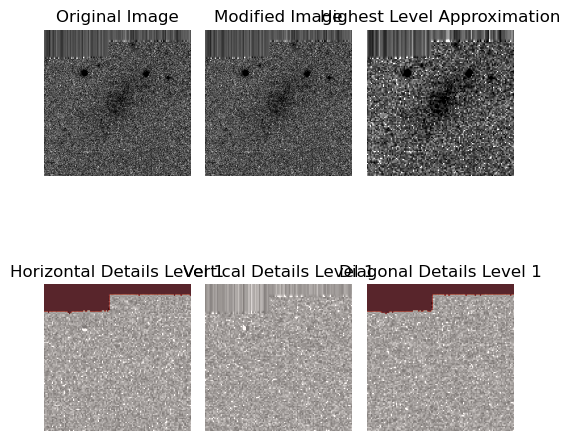

Took 0.17 seconds.
[[False False False]
 [ True False  True]]


In [9]:
file_dir = '/home/nick/astro/UNIONS/lsb-detection-pipeline/NGC5457_test/fields/CFIS_LSB.243.290.r'
cutout_260_284 = read_h5(os.path.join(file_dir, '246_289_224x224_ugriz.h5'))
data_img = cutout_260_284['images'][7][4]

start = time.time()
anomalies = detect_anomaly(data_img, file_dir, '246_289_anomaly', wavelet='haar', levels=1, zero_threshold=0.0025, min_size=20, bkg_rms=0., replace_anomaly=False, dilate_mask=True, dilation_iters=1, show_plot=True, save_plot=False)
print(f'Took {np.round(time.time()-start, 2)} seconds.')
print(anomalies)

In [9]:
np.zeros((2,3), dtype=bool)[1]

array([False, False, False])

In [92]:
224/125

1.792

In [147]:
np.all(pywt.dwt2(data_img, 'db1')[1][2] == pywt.dwt2(data_img, 'haar')[1][2])

True

In [155]:
pywt.wavedec2(data_img, 'db1', level=2)[1][0].shape

(56, 56)

In [164]:
pywt.dwt2(data_img, 'db2')[1][0].shape

(113, 113)

In [260]:
coeffs = pywt.wavedec2(data_img, 'db1', level=2)  # Use the wavelet parameter
approx = coeffs[0]
details = coeffs[1:]

In [264]:
len(details[1])

3

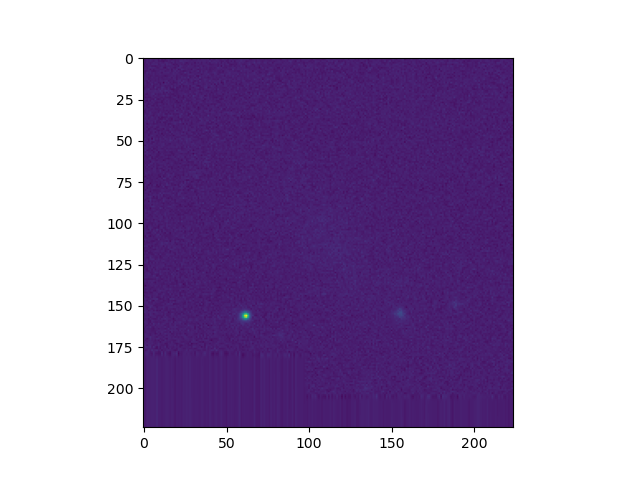

In [8]:
plt.figure()
plt.imshow(data_img)
plt.show()